## Data Transformation and Extraction
Convert pdf to image file and extract table text using optical character recognition (OCR)

In [1]:
# Load required packages
import cv2
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

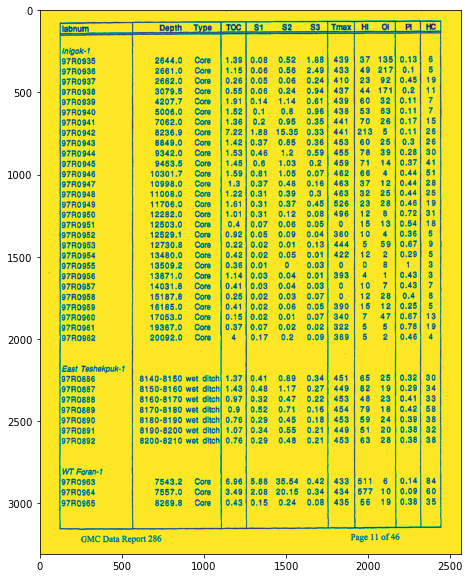

In [2]:
# Convert pdf to image file
pdf = r'C:/Users/Aditya/Scanned PDF/gmc286.pdf'
pages = convert_from_path(pdf, 300, first_page = 12, last_page = 12)

# Save into a new file
i = 11
for page in pages:
    image_name = 'Page_' + str(i) + '.jpg'  
    page.save(image_name, 'JPEG')
    i = i    
    
# Load the original image
image = cv2.imread('Page_11.jpg', cv2.IMREAD_GRAYSCALE)
original = image.copy()
plt.figure(figsize=(10,10))
plt.imshow(image)

In [3]:
# Load required packages
import pytesseract
import csv
import pandas as pd
from pytesseract import Output
from PIL import Image

In [4]:
# Set path for pytesseract package
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files (x86)/Tesseract-OCR/tesseract.exe'

In [5]:
# Perform image pre-processing technique
blur = cv2.GaussianBlur(image, (7, 7), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 13))
dilate = cv2.dilate(thresh, kernel, iterations = 1)

In [6]:
# Set contour parameters
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key = lambda x: cv2.boundingRect(x)[0])

roi_number = 0
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    if h > 200 and w > 20:
        roi = image[y:y+h, x:x+w]
        cv2.imwrite('C:/Users/Aditya/Scanned PDF/Images/ROI_{}.jpg'.format(roi_number), roi)
        cv2.rectangle(image, (x, y), (x + w, y + h), (36, 255, 12), 2)
        roi_number += 1

In [7]:
# Set path for pytesseract package
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files (x86)/Tesseract-OCR/tesseract.exe'

In [8]:
# Set path for after-processed image
image_file = r'C:/Users/Aditya/Scanned PDF/Images/ROI_0.jpg'
img = Image.open(image_file)

In [9]:
# Convert text image to string
custom_config = r'-l eng --oem 3 --psm 6 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789-:.$%./@& *"'
output = pytesseract.image_to_data(img, config = custom_config, output_type = Output.DICT)
data = pd.DataFrame(output)

# Clean up blanks
data1 = data[(data.conf != '-1') & (data.text != ' ') & (data.text != '')]
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Sort blocks vertically
sorted_blocks = data1.groupby('block_num').first().sort_values('top').index.tolist()
for block in sorted_blocks:
    curr = data1[data1['block_num'] == block]
    sel = curr[curr.text.str.len() > 3]
    # sel = curr
    char_w = (sel.width / sel.text.str.len()).mean()
    prev_par, prev_line, prev_left = 0, 0, 0
    text = ''
    for ix, ln in curr.iterrows():
        # Add new line when necessary
        if prev_par != ln['par_num']:
            text += '\n'
            prev_par = ln['par_num']
            prev_line = ln['line_num']
            prev_left = 0
        elif prev_line != ln['line_num']:
            text += '\n'
            prev_line = ln['line_num']
            prev_left = 0

        added = 0  
        if ln['left'] / char_w > prev_left + 1:
            added = int((ln['left']) / char_w) - prev_left
            text += ' ' * added
        text += ln['text'] + ' '
        prev_left += len(ln['text']) + added + 1
    text += '\n'
    print(text)

# Open text as csv file    
with open('results.csv', 'w') as f:
    f.write(text)


fabnum              Depth     type   TOC    Si   S2    $3    Tmax    Hl  OF    MI  HC 
Inigok-1 
97R0935              2644.0    Core   1.8910.08   0.52  1.88  439   37  135/0.13    6 
97R0936              2661.0    Core   1.15/0.06   0.56  2.49/ 433   49  217   0.1   5 
97R0937              2662.0    Core   0.2610.05   0.06  0.24  410/  23   92/0.45   19 
97R0938              3079.5    Core   0.5510.06   0.24  0.94  437144    171   0.2 3 11 
97R0939              4207.7    Core   11.9110.14 1.14   0.61  439160     32/0.11    7 
97R0940              5006.0    Core   1.521 0.1   0.8   0.96/ 4388153    631/0.11   7 
97R0941              7062.0    Core   1.36  0.2   0.95  0.85  441   70   2610.17   15 
97R0942              8236.9    Core / 7.221.88   15.35  0.839 441   213  5   0.11  26 
97R0943              8849.0    Core   1.420.37    0.85 0.86   453   60   25   0.3  26 
97R0944              9342.0    Core   /1.53/0.46  1.2   0.59  455   178  39  0.28  30 
97R0945               9453.5   

## Data Cleaning
Restructure data frame and check if the values are valid

In [10]:
# Load data frame
df = pd.read_csv('results.csv')
print(df.shape)
print(df.head())

# Change name of the column
df = df.rename(columns = {df.columns[0]: 'raw'})

# Convert data type to string
df = df.convert_dtypes()
print(df.info())

# Replace unnecessary character
df['raw'] = df['raw'].str.replace('/', '')
print(df.head())

(41, 1)
  fabnum              Depth     type   TOC    Si   S2    $3    Tmax    Hl  OF    MI  HC 
0                                          Inigok-1                                     
1  97R0935              2644.0    Core   1.8910.0...                                    
2  97R0936              2661.0    Core   1.15/0.0...                                    
3  97R0937              2662.0    Core   0.2610.0...                                    
4  97R0938              3079.5    Core   0.5510.0...                                    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   raw     41 non-null     string
dtypes: string(1)
memory usage: 456.0 bytes
None
                                                 raw
0                                          Inigok-1 
1  97R0935              2644.0    Core   1.8910.0...
2  97R0936              2661.0    Core  

In [11]:
# Split a single column to multiple columns
df = pd.DataFrame(df['raw'].str.split().values.tolist())
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Inigok-1,None,None,None,None,None,None,None,None,None,None,None,None
1,97R0935,2644.0,Core,1.8910.08,0.52,1.88,439,37,1350.13,6,None,None,None
2,97R0936,2661.0,Core,1.150.06,0.56,2.49,433,49,217,0.1,5,None,None
3,97R0937,2662.0,Core,0.2610.05,0.06,0.24,410,23,920.45,19,None,None,None
4,97R0938,3079.5,Core,0.5510.06,0.24,0.94,437144,171,0.2,3,11,None,None


In [12]:
# Copy df to clipboard for editing in excel
df.to_clipboard()

# Load new data frame
df_new = pd.read_csv('new_results.csv')
df_new.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Inigok-1,97R0935,2644.0,core,1.39,0.08,0.52,1.88,439.0,37.0,135.0,0.13,6.0
1,Inigok-1,97R0936,2661.0,core,1.15,0.06,0.56,2.49,433.0,49.0,217.0,0.10,5.0
2,Inigok-1,97R0937,2662.0,core,0.26,0.05,0.06,0.24,410.0,23.0,92.0,0.45,19.0
3,Inigok-1,97R0938,3079.5,core,0.55,0.06,0.24,0.94,437.0,44.0,171.0,0.20,11.0
4,Inigok-1,97R0939,4207.7,core,1.91,0.14,1.14,0.61,439.0,60.0,32.0,0.11,7.0


In [13]:
# Assign new column names
columns = ['well_name', 'labnum', 'depth', 'type', 'toc', 's1', 's2', 's3', 'tmax', 'hi', 'oi', 'pi', 'hc']
df_new.columns = columns
df_new.head()

,well_name,labnum,depth,type,toc,s1,s2,s3,tmax,hi,oi,pi,hc
0,Inigok-1,97R0935,2644.0,core,1.39,0.08,0.52,1.88,439.0,37.0,135.0,0.13,6.0
1,Inigok-1,97R0936,2661.0,core,1.15,0.06,0.56,2.49,433.0,49.0,217.0,0.10,5.0
2,Inigok-1,97R0937,2662.0,core,0.26,0.05,0.06,0.24,410.0,23.0,92.0,0.45,19.0
3,Inigok-1,97R0938,3079.5,core,0.55,0.06,0.24,0.94,437.0,44.0,171.0,0.20,11.0
4,Inigok-1,97R0939,4207.7,core,1.91,0.14,1.14,0.61,439.0,60.0,32.0,0.11,7.0


In [14]:
# Convert some columns from object to string data type
df_new['well_name'] = df_new['well_name'].convert_dtypes()
df_new['labnum'] = df_new['labnum'].convert_dtypes()
df_new['type'] = df_new['type'].convert_dtypes()
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   well_name  38 non-null     string 
 1   labnum     38 non-null     string 
 2   depth      38 non-null     float64
 3   type       38 non-null     string 
 4   toc        38 non-null     float64
 5   s1         38 non-null     float64
 6   s2         38 non-null     float64
 7   s3         38 non-null     float64
 8   tmax       38 non-null     float64
 9   hi         38 non-null     float64
 10  oi         38 non-null     float64
 11  pi         38 non-null     float64
 12  hc         38 non-null     float64
dtypes: float64(10), string(3)
memory usage: 4.0 KB


## Visualization
A series of subplots of the Inigok-1 well geochemical data

In [15]:
# Load required packages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

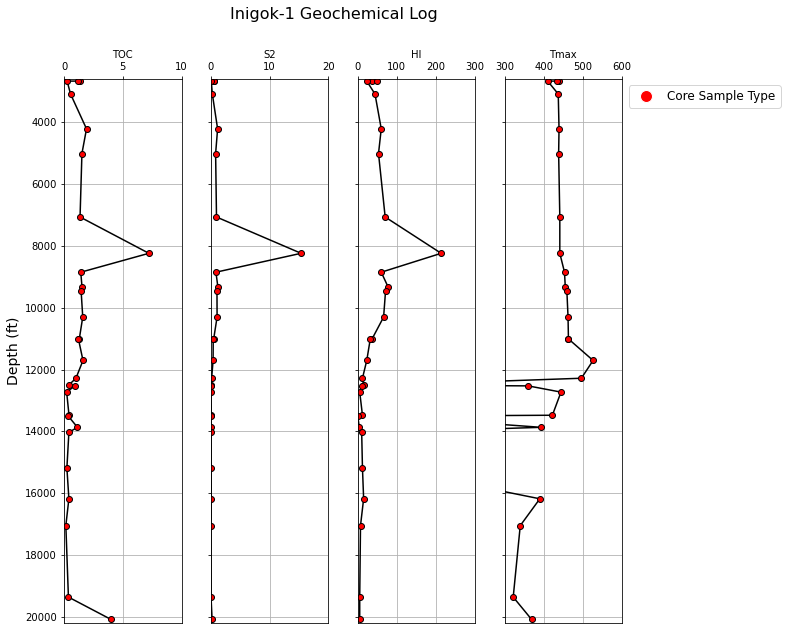

In [16]:
# Filter data frame with only Inigok-1 well
df_in = df_new.iloc[:28]

# Set parameters for figure plots
fig, axes = plt.subplots(figsize = (10, 10))
curve_names = ['TOC', 'S2', 'HI', 'Tmax']

# Set the plot axes
ax1 = plt.subplot2grid((1,4), (0,0), rowspan = 1, colspan = 1)
ax2 = plt.subplot2grid((1,4), (0,1), rowspan = 1, colspan = 1)
ax3 = plt.subplot2grid((1,4), (0,2), rowspan = 1, colspan = 1)
ax4 = plt.subplot2grid((1,4), (0,3), rowspan = 1, colspan = 1)

# Set up individual plot parameters
ax1.plot('toc', 'depth', data = df_in, color = 'black', marker = 'o', mfc = 'red', label = 'line with marker')
ax1.set_xlim(0, 10)

ax2.plot('s2', 'depth', data = df_in, color = 'black', marker = 'o', mfc = 'red', label = 'line with marker')
ax2.set_xlim(0, 20)

ax3.plot('hi', 'depth', data = df_in, color = 'black', marker = 'o', mfc = 'red', label = 'line with marker')
ax3.set_xlim(0, 300)

ax4.plot('tmax', 'depth', data = df_in, color = 'black', marker = 'o', mfc = 'red', label = 'line with marker')
ax4.set_xlim(300, 600)

# Set common parameters for all of the plots
for i, ax in enumerate(fig.axes):
    ax.set_ylim(20200, 2600)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_xlabel(curve_names[i])
    ax.grid()

# Hide the tick labels on y-axis
for ax in [ax2, ax3, ax4]:
    plt.setp(ax.get_yticklabels(), visible = False)

# Reduce space between each plot
fig.subplots_adjust(wspace = 0.25)

# Create title and y-label
fig.suptitle('Inigok-1 Geochemical Log', fontsize = 16)
ax1.set_ylabel('Depth (ft)', fontsize = '14')

# Draw a legend
red =  Line2D([0], [0], marker = 'o', color = 'w', label = 'Core Sample Type',
                        markerfacecolor = 'red', markersize = 12),
plt.legend(handles = red, bbox_to_anchor = (2.4, 1), loc = 1, fontsize = 12)